In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [2]:
import matplotlib.pyplot as plt
import torch
from sdm.models import S2Dataset

In [3]:
from torchvision.transforms import v2
img_transforms = v2.Compose([
    # Rotate
    v2.RandomRotation(30, expand=True),
    # Flip
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.2),
    # Affine
    v2.RandomAffine(10, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
    v2.Resize((304, 304)),
])

In [4]:
dataset = S2Dataset(transforms=img_transforms)
n_input_bands = len(dataset.input_bands)

In [5]:
# import dataloader and split into train and validation
from torch.utils.data import DataLoader, random_split

batch_size = 32
validation_split = .2


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)

test_dataloader.dataset.dataset.transforms = None

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# set mac m1 device
device = torch.device('mps')

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, tile_size=304):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # output 1 channel

        # Match the number of output channels with the input for skip connection
        self.match_dim = nn.Conv2d(in_channels, 1, kernel_size=1)  # 1x1 convolution

    def forward(self, x):
        original_x = x
        x = self.bn1(nn.functional.relu(self.conv1(x)))
        x = nn.functional.relu(self.conv2(x))
        x = self.conv3(x)

        # Match the dimensions
        original_x = self.match_dim(original_x)
        
        # Add the skip connection
        x = x + original_x  # element-wise addition

        return x.squeeze(1)



# Initialize the model, loss, and optimizer
model = SimpleCNN(n_input_bands)
criterion = nn.MSELoss()  # Mean Squared Error for regression task
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = model.to(device)
criterion = criterion.to(device)

loss_results = []

# Training loop
model.train()
n_epochs = 10  # Number of epochs
early_stop = 3  # Stop if the validation loss does not improve after 5 epochs
best_val_loss = 1e10  # Set initial best validation loss to infinity
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0
    for i, (inputs, target, idxs) in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        target = target.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Epoch {epoch}/{n_epochs} Batch {i+1}/{len(train_dataloader)} Loss: {loss.item():.4f} RMSE: {loss.item()**0.5:.4f}")
    avg_loss_train = epoch_loss/len(train_dataloader)
    print(f"Epoch {epoch}/{n_epochs} Loss: {avg_loss_train} RMSE: {avg_loss_train**0.5:.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for i, (inputs, target, idxs) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            target = target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, target)
            epoch_loss += loss.item()
        avg_loss_val = epoch_loss/len(test_dataloader)
        
        print(f"Epoch {epoch}/{n_epochs} Validation Loss: {avg_loss_val} RMSE: {avg_loss_val**0.5:.4f}")
    
    loss_results.append({'train': avg_loss_train, 'val': avg_loss_val})
    scheduler.step()
    # Early stopping
    if avg_loss_val < best_val_loss:
        best_val_loss = avg_loss_val
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stop:
            print('Early stopping!')
            break

# Save the model
# torch.save(model.state_dict(), "simple_cnn_model.pth")


Epoch 1/10 Batch 1/14 Loss: 7.1993 RMSE: 2.6832
Epoch 1/10 Batch 2/14 Loss: 7.3890 RMSE: 2.7183
Epoch 1/10 Batch 3/14 Loss: 9.0861 RMSE: 3.0143
Epoch 1/10 Batch 4/14 Loss: 6.6959 RMSE: 2.5877
Epoch 1/10 Batch 5/14 Loss: 4.8144 RMSE: 2.1942
Epoch 1/10 Batch 6/14 Loss: 2.3443 RMSE: 1.5311
Epoch 1/10 Batch 7/14 Loss: 2.5861 RMSE: 1.6082
Epoch 1/10 Batch 8/14 Loss: 2.1137 RMSE: 1.4539
Epoch 1/10 Batch 9/14 Loss: 2.3631 RMSE: 1.5372
Epoch 1/10 Batch 10/14 Loss: 3.0171 RMSE: 1.7370
Epoch 1/10 Batch 11/14 Loss: 3.3249 RMSE: 1.8234
Epoch 1/10 Batch 12/14 Loss: 2.8855 RMSE: 1.6987
Epoch 1/10 Batch 13/14 Loss: 3.0593 RMSE: 1.7491
Epoch 1/10 Batch 14/14 Loss: 2.4211 RMSE: 1.5560
Epoch 1/10 Loss: 4.235701748303005 RMSE: 2.0581
Epoch 1/10 Validation Loss: 25.01048892736435 RMSE: 5.0010
Epoch 2/10 Batch 1/14 Loss: 8.8538 RMSE: 2.9755
Epoch 2/10 Batch 2/14 Loss: 5.2742 RMSE: 2.2966
Epoch 2/10 Batch 3/14 Loss: 7.2109 RMSE: 2.6853
Epoch 2/10 Batch 4/14 Loss: 11.2200 RMSE: 3.3496
Epoch 2/10 Batch 5/14 L

<Axes: >

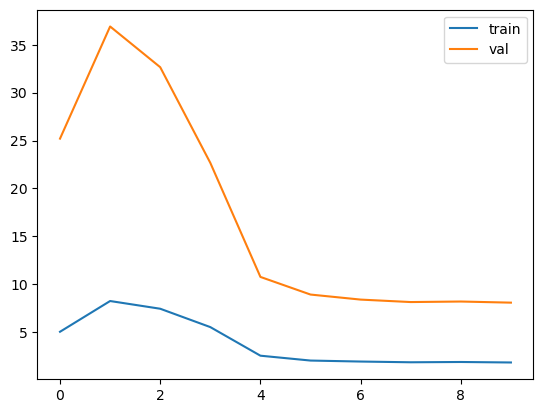

In [ ]:
import pandas as pd
loss_df =  pd.DataFrame(loss_results)
loss_df.plot()

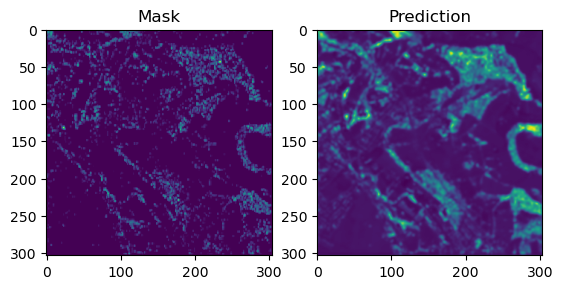

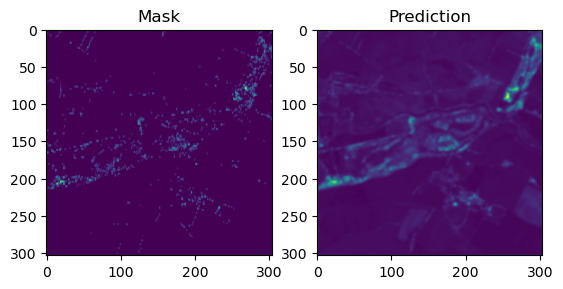

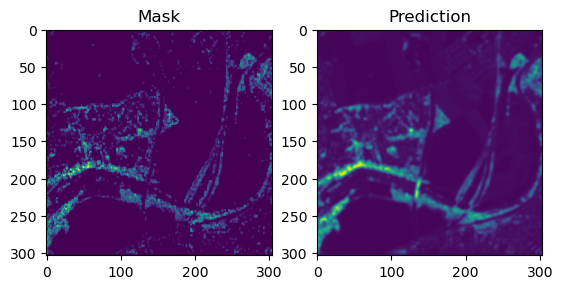

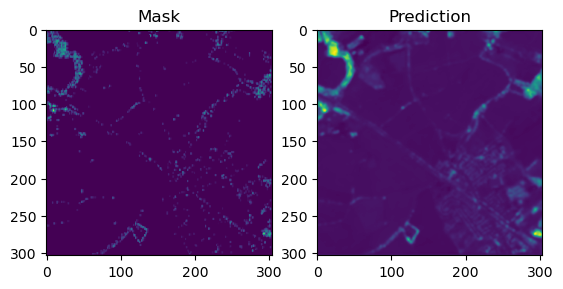

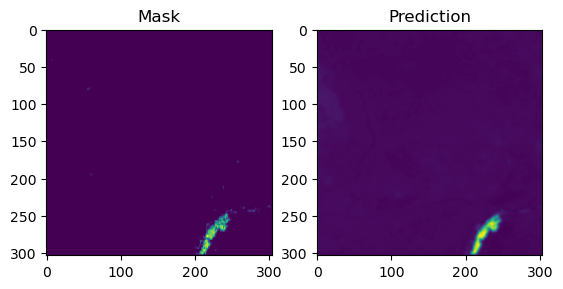

In [31]:
from sdm.models import SpatialTransformer, plot_predictions

model.eval()

# Make some predictions and plot the mask and the prediction in sub plots
arrays = []
with torch.no_grad():
    for i, (inputs, target, idxs) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        target = target.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, target)

        target_np = target.cpu().numpy()
        prediction_np = outputs.cpu().numpy()

        # iterate over the batch
        for i in range(len(target_np)):
            arrays.append({"target": target_np[i], "prediction": prediction_np[i]})
        

for i in range(5):
    plot_predictions(arrays[i]["target"], arrays[i]["prediction"])

In [3]:
# Save the model
torch.save(model.state_dict(), "models/veg-height-cnn.pth")

NameError: name 'model' is not defined

In [16]:
import numpy as np
torch.LongTensor([2])

tensor([2])